## Ellipsis in Turkish

In [ ]:
!pip install turkish-lm-tuner 

In [1]:
# Importing the t5 model
from transformers import AutoTokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("boun-tabi-LMG/TURNA")
tokenizer = AutoTokenizer.from_pretrained("boun-tabi-LMG/TURNA")

In [2]:
input_ids = tokenizer(
    '[S2S] Merhaba, benim adım ayşe ve<EOS>', return_tensors='pt'
).input_ids

outputs = model.generate(
    input_ids,
    max_length=128,
    length_penalty=1,
    top_k=10,
    top_p=0.95,
    temperature=1,
    no_repeat_ngram_size=3,
    repetition_penalty=3.1,
    num_beams=5,
    do_sample=True,
)

'<PAD> ben bu siteyi yeni keşfettim ve gerçekten çok beğendim. Bu siteye üye olmak istiyorum fakat bir türlü üye olamıyorum. Lütfen bana yardımcı olur musunuz? Merhaba, benim adım ayşe ve ben bu sitede yeniyim. Üye olmak istiyorum ama nasıl üye olacağımı bilmiyorum. Yardımcı olabilirseniz çok sevinirim. Siteye üye olmak için ne yapmam gerekiyor? Üyeliğimi nasıl iptal edebilirim? Üyelik iptali hakkında bilgi verir misiniz? Bir dahaki sefere yorum yaptığımda kullanılmak üzere adımı, e-posta adresimi ve web site adresimi bu tarayıcıya kaydet. İlk yorumu yukarıdaki form aracılığıyla siz yapabilirsiniz. Yayınlanan kahve falı yorumları, rüya tabirleri, astroloji yorumları'

In [3]:
input_ids = tokenizer(
    '[S2S] Merhaba, benim adım ayşe ve<EOS>', return_tensors='pt'
).input_ids

inputs_embeds = model.shared(input_ids)

outputs = model.generate(
    input_ids=None,
    inputs_embeds=inputs_embeds,
    max_length=128,
    length_penalty=1,
    top_k=10,
    top_p=0.95,
    temperature=1,
    no_repeat_ngram_size=3,
    repetition_penalty=3.1,
    num_beams=5,
    do_sample=True,
)


In [10]:
tokenizer.convert_ids_to_tokens([model.generation_config.decoder_start_token_id])

['<PAD>']

In [20]:
tokenizer(
    '[S2S] Merhaba, benim adım ayşe ve<EOS>', 
    text_target='<PAD> Ben kimim bilmiyorum',
    return_tensors='pt'
)

{'input_ids': tensor([[    9, 31997,  2813,     5,   243,  1004,   326,  3160,     6,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[   0,  217, 2350,   25, 2170]])}

In [ ]:
from turkish_lm_tuner import DatasetProcessor, TrainerForConditionalGeneration

dataset_name = "tr_news"
task = "summarization"
task_format="conditional_generation"
model_name = "boun-tabi-LMG/TURNA"
max_input_length = 764
max_target_length = 128
dataset_processor = DatasetProcessor(
    dataset_name=dataset_name, task=task, task_format=task_format, task_mode='',
    tokenizer_name=model_name, max_input_length=max_input_length, max_target_length=max_target_length
)

train_dataset = dataset_processor.load_and_preprocess_data(split='train')
eval_dataset = dataset_processor.load_and_preprocess_data(split='validation')
test_dataset = dataset_processor.load_and_preprocess_data(split="test")

training_params = {
    'num_train_epochs': 10,
    'per_device_train_batch_size': 4,
    'per_device_eval_batch_size': 4,
    'output_dir': './', 
    'evaluation_strategy': 'epoch',
    'save_strategy': 'epoch',
    'predict_with_generate': True    
}
optimizer_params = {
    'optimizer_type': 'adafactor',
    'scheduler': False,
}

In [ ]:
dataset_processor.tokenizer.eos_token

In [ ]:
# Decode input_ids and labels
print(tokenizer.decode(train_dataset[0]['input_ids']))
print(tokenizer.decode(train_dataset[0]['labels']))

Tuğba Özerk, “Duymayan Kalmasın” programında, annesi Günay Kapani’ye “Kızınızla aranız bozukmuş. Gerçekten onun sevgilisiyle birlikte oldunuz mu?” diye soran Deniz Akkaya’ya dava açtı. Ünlü şarkıcı, konuyla ilgili şöyle dedi: “Canlı yayında anneme akıl almaz bir soru yöneltti. Neye uğradığını şaşırdı kadın. Telefonu kapattıktan sonra rahatsızlandı. Deniz Akkaya hakkında suç duyurusunda bulundum, 100 bin liralık manevi tazminat davası açtım. Tazminatın tamamını şehit ailelerine bağışlayacağım.”<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P

### Load And Format Dataset

In [24]:
import os
import json
import pandas as pd

with open(
    '../Datasets/ellipsisdb.latest.json', 'r', encoding='utf-8'
) as f:
    
    data = json.load(f)

In [25]:
ellipsis_df = pd.DataFrame(data)

In [26]:
ellipsis_df['_id'] = ellipsis_df['_id'].apply(lambda x: x['$oid'])

In [27]:
ellipsis_df = ellipsis_df.explode('annotation')

In [28]:
annotation_keys = ellipsis_df.annotation.iloc[0].keys()

for key in annotation_keys:
    ellipsis_df[key] = ellipsis_df.annotation.apply(lambda x: x[key] if key in x else None)

In [29]:
ellipsis_df.columns

Index(['_id', 'candidate_id', 'candidate_text', 'previous_context',
       'next_context', 'provenance', 'annotation', 'acquisition_method',
       'timestamp', 'parse', 'human_annotation_status', 'annotation_type',
       'annotator_id', 'annotation_time', 'annotator_type', 'elliptical_type',
       'span', 'correlate', 'sentence_quality', 'annotator_note',
       'resolved_annotation'],
      dtype='object')

In [30]:
ellipsis_df = ellipsis_df[[
    '_id', 'candidate_id', 'candidate_text','provenance', 'acquisition_method', 'annotation_type',
    'previous_context', 'next_context', 'annotator_id', 'elliptical_type', 'span', 'sentence_quality', 'correlate' 
]]

In [ ]:
# SEED + AUGMENT -> RELEASE
# TRAIN WITH THIS DATA

<AxesSubplot: xlabel='sentence_quality', ylabel='count'>

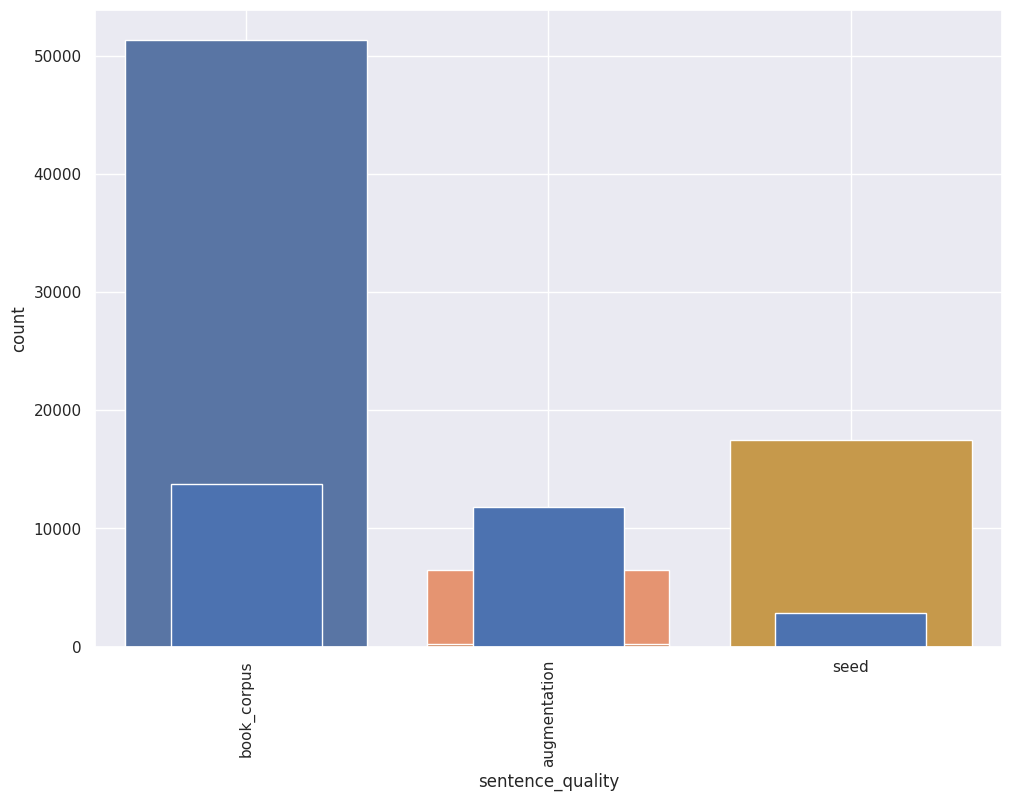

In [44]:
# use seaborn 
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='elliptical_type', data=ellipsis_df)
sns.countplot(x='sentence_quality', data=ellipsis_df)

ellipsis_df.drop_duplicates('candidate_id').provenance.value_counts().plot(kind='bar')

In [32]:
ellipsis_df.elliptical_type = ellipsis_df.elliptical_type.replace({
    'arg_drop': 'Argument Drop',
    'np_drop': 'NP Drop',
    'obj_drop': 'Object Drop',
})

In [33]:
accepted = [
    'Gapping', 
    'Object Drop', 
    'VP Ellipsis', 
    'Argument Drop',
    'Subject Drop', 
    'Genitive Drop',
    'Stripping', 
    'No Ellipsis',
    'Object CP Drop',
    'Ki Expression', 
    # 'Ungrammatical', 
    'Fragment',
    # None, 
    # 'd',
    'Sluicing', 
    # 'similarity', 
    'NP Drop',
    'Pronominal Strategy', 
    'Subject CP Drop', 
    # '?', 
    # 'default'
]

In [43]:
ellipsis_df = ellipsis_df[ellipsis_df.elliptical_type.isin(accepted)]

correlate = ellipsis_df[ellipsis_df.correlate != '']
correlate = correlate[correlate.correlate != 'None']
correlate = correlate[correlate.correlate.isna() == False]

correlate._id.unique()

array(['64a653f3fb042427a079607b', '64a653f3fb042427a079607c',
       '64a653f3fb042427a079607d', ..., '651aa2b64cde1bbbaf635e58',
       '651aa3184cde1bbbaf635e59', '651aa31c4cde1bbbaf635e5a'],
      dtype=object)

### Calculate Inter-annotator Agreement

<AxesSubplot: >

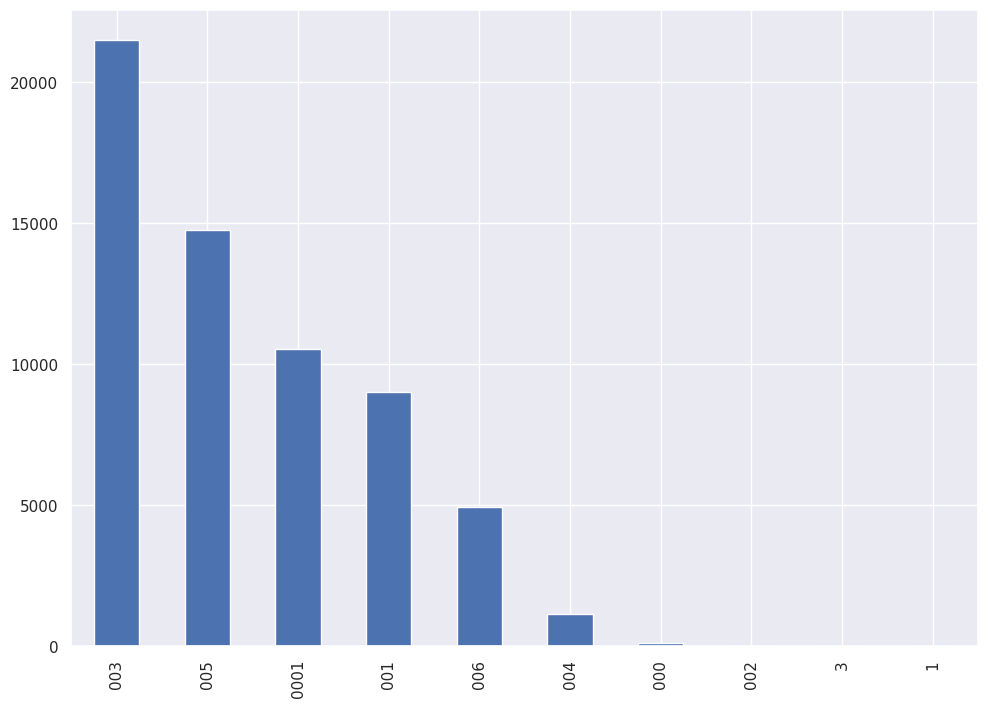

In [45]:
ellipsis_df.annotator_id.value_counts().plot(kind='bar')

In [46]:
# First sort by candidate_id and then by annotator_id, then elliptical_type
ellipsis_df = ellipsis_df.sort_values(
    by=['candidate_id', 'annotator_id', 'elliptical_type']
)

In [47]:
ellipsis_df[[
    'candidate_id', 'annotator_id', 'elliptical_type', 'candidate_text', 'span'
]]

,candidate_id,annotator_id,elliptical_type,candidate_text,span
1912,1mane_0_13152,0001,Gapping,"O da üzül­dü, ben de.",None
1912,1mane_0_13152,001,Gapping,"O da üzül­dü, ben de.","[üzül­dü,]"
1912,1mane_0_13152,006,Gapping,"O da üzül­dü, ben de.","[üzül­dü,]"
49,1smc_0_980,0001,Object Drop,"Görüntüler beni bile pek çok kez hasta etti, a...",None
49,1smc_0_980,002,VP Ellipsis,"Görüntüler beni bile pek çok kez hasta etti, a...","[{'value': [{'start': 6, 'end': 8, 'tokens': [..."
...,...,...,...,...,...
156,zytyo_0_2273,0001,Genitive Drop,Irmak çölde kaybolduğunu görüyordu ama kaderin...,None
156,zytyo_0_2273,001,Genitive Drop,Irmak çölde kaybolduğunu görüyordu ama kaderin...,[Irmak]
156,zytyo_0_2273,003,Genitive Drop,Irmak çölde kaybolduğunu görüyordu ama kaderin...,[Irmak]
156,zytyo_0_2273,003,Genitive Drop,Irmak çölde kaybolduğunu görüyordu ama kaderin...,[Irmak]


In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa

# Sample function to calculate Cohen's Kappa between two annotators
def calculate_cohens_kappa(data, annotator1, annotator2):
    # Filter data for the two specified annotators
    data = data[[
        'candidate_id', 'annotator_id', 'elliptical_type', 'candidate_text', 'span'
    ]].drop_duplicates(
        subset=['candidate_id', 'annotator_id', 'elliptical_type']
    )

    subset = data[data['annotator_id'].isin([annotator1, annotator2])]
    # Pivot table so each row represents a dataset_id and each column an annotator's label
    pivoted_data = subset.pivot_table(index='candidate_id', columns='annotator_id', values='elliptical_type', aggfunc='first')
    # Drop rows with missing annotations
    pivoted_data = pivoted_data.dropna()
    # Extract labels for the two annotators
    labels_1 = pivoted_data[annotator1]
    labels_2 = pivoted_data[annotator2]
    # Calculate and return Cohen's Kappa
    return cohen_kappa_score(labels_1, labels_2)

# Sample function to calculate Fleiss' Kappa across all annotators
def calculate_fleiss_kappa(data):
    data = data[[
        'candidate_id', 'annotator_id', 'elliptical_type', 'candidate_text', 'span'
    ]].drop_duplicates(
        subset=['candidate_id', 'annotator_id', 'elliptical_type']
    )
    # Create a pivot table where each row represents a candidate_id and each column a unique label
    label_counts = data.pivot_table(index='candidate_id', columns='elliptical_type', aggfunc='size', fill_value=0)
    # Convert to numpy array for Fleiss Kappa calculation
    label_matrix = label_counts.values

    print(label_matrix.shape)
    # Calculate and return Fleiss' Kappa
    return fleiss_kappa(label_matrix)

In [ ]:
# Calculate Cohen's Kappa between all annotator combinations
annotator_ids = ellipsis_df.annotator_id.unique()
kappa_scores = []
for i, annotator1 in enumerate(annotator_ids):
    for j, annotator2 in enumerate(annotator_ids):
        if i < j:
            kappa = calculate_cohens_kappa(ellipsis_df, annotator1, annotator2)
            kappa_scores.append((annotator1, annotator2, kappa))


# Calculate Fleiss' Kappa across all annotators
# fleiss_kappa_score = calculate_fleiss_kappa(ellipsis_df)

In [ ]:
KAPPA_DF = pd.DataFrame(kappa_scores, 
             columns=['annotator1', 'annotator2', 'kappa'])\
            .sort_values(by='kappa', ascending=False)

In [53]:
KAPPA_DF

,annotator1,annotator2,kappa
14,001,000,0.811321
19,006,005,0.683183
13,001,003,0.675227
32,004,000,0.672131
35,005,003,0.635821
20,006,003,0.633745
11,001,004,0.621670
12,001,005,0.605831
5,0001,003,0.594266
31,004,003,0.575548


### Create Classification Dataset

In [93]:
# Drop if same annotator_id and elliptical_type for the same candidate_id
classification_df = ellipsis_df[[
    'candidate_id', 'annotator_id', 'elliptical_type', 'candidate_text', 'span', 'sentence_quality'
]].drop_duplicates(
    subset=['candidate_id', 'annotator_id', 'elliptical_type']
)

In [94]:
# Drop if sentence_quality is False
classification_df = classification_df[classification_df.sentence_quality.isin([
    None, True
])]
# Drop if same annotator_id and elliptical_type for the same candidate_id
classification_df = classification_df.drop_duplicates(
    subset=['candidate_id', 'elliptical_type']
)

In [95]:
# Drop if TBD
classification_df = classification_df[classification_df.elliptical_type != 'TBD']
classification_df

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality
1912,1mane_0_13152,0001,Gapping,"O da üzül­dü, ben de.",None,None
49,1smc_0_980,0001,Object Drop,"Görüntüler beni bile pek çok kez hasta etti, a...",None,None
49,1smc_0_980,002,VP Ellipsis,"Görüntüler beni bile pek çok kez hasta etti, a...","[{'value': [{'start': 6, 'end': 8, 'tokens': [...",True
49,1smc_0_980,004,Argument Drop,"Görüntüler beni bile pek çok kez hasta etti, a...",[Görüntüler],True
1075,"1yjtdbusb,sa_0_943",0001,Subject Drop,20. yüzyıl tarihçiliği bu tür soruları sormadı...,None,None
...,...,...,...,...,...,...
1917,zune_0_2653,0001,Gapping,Avrupalılar kendi kurallarına göre davranmakta...,None,None
278,zvmbsrmp_0_1351,0001,Subject Drop,"Konunun sürüp gitmesi beni üzüyor, ama onlara ...",None,None
278,zvmbsrmp_0_1351,001,Genitive Drop,"Konunun sürüp gitmesi beni üzüyor, ama onlara ...",[beni],True
279,zvmbsrmp_0_5864,0001,Genitive Drop,"Verilen bilgiye göre orman, boşluğu yeniden do...",None,None


<AxesSubplot: >

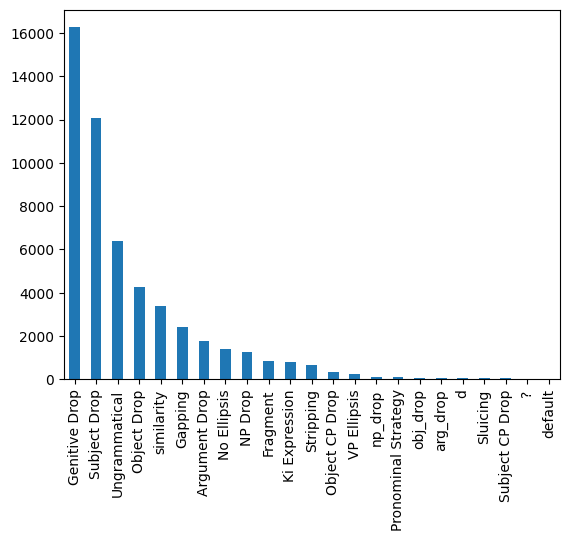

In [99]:
classification_df.elliptical_type.value_counts().plot(kind='bar')

In [101]:
classification_df.elliptical_type.value_counts()

Genitive Drop          16270
Subject Drop           12084
Ungrammatical           6406
Object Drop             4241
similarity              3374
Gapping                 2389
Argument Drop           1770
No Ellipsis             1381
NP Drop                 1247
Fragment                 826
Ki Expression            805
Stripping                652
Object CP Drop           315
VP Ellipsis              228
np_drop                  112
Pronominal Strategy       78
obj_drop                  71
arg_drop                  68
d                         40
Sluicing                  37
Subject CP Drop           31
?                          7
default                    1
Name: elliptical_type, dtype: int64

In [104]:
classification_df.elliptical_type = classification_df.elliptical_type.replace({
    'arg_drop': 'Argument Drop',
    'np_drop': 'NP Drop',
    'obj_drop': 'Object Drop',
})

In [106]:
accepted = [
    'Gapping', 
    'Object Drop', 
    'VP Ellipsis', 
    'Argument Drop',
    'Subject Drop', 
    'Genitive Drop',
    'Stripping', 
    'No Ellipsis',
    'Object CP Drop',
    'Ki Expression', 
    # 'Ungrammatical', 
    'Fragment',
    # None, 
    # 'd',
    'Sluicing', 
    # 'similarity', 
    'NP Drop',
    'Pronominal Strategy', 
    'Subject CP Drop', 
    # '?', 
    # 'default'
]

In [107]:
print('Dataset shape before filtering:', classification_df.shape)
print('Dataset shape after filtering:', classification_df[classification_df.elliptical_type.isin(accepted)].shape )

Dataset shape before filtering: (77569, 6)
Dataset shape after filtering: (42605, 6)


In [108]:
classification_df = classification_df[classification_df.elliptical_type.isin(accepted)]

In [111]:
from sklearn.model_selection import train_test_split    

train_df, test_df = train_test_split(
    classification_df, 
    stratify=classification_df['elliptical_type'], 
    test_size=0.1, random_state=42
)

train_df, val_df = train_test_split(
    train_df, 
    stratify=train_df['elliptical_type'], 
    test_size=0.1, random_state=42
)

In [113]:
# Create dataframe value counts for training, validation, and test datasets
train_value_counts = train_df.elliptical_type.value_counts()
val_value_counts = val_df.elliptical_type.value_counts()
test_value_counts = test_df.elliptical_type.value_counts()

# Combine the value counts into a single dataframe
combined_value_counts = pd.concat(
    [train_value_counts, val_value_counts, test_value_counts], 
    axis=1, 
    keys=['train', 'validation', 'test']
)

# Display the combined value counts
combined_value_counts

,train,validation,test
Genitive Drop,13178,1465,1627
Subject Drop,9787,1088,1209
Object Drop,3493,388,431
Gapping,1935,215,239
Argument Drop,1489,165,184
No Ellipsis,1119,124,138
NP Drop,1101,122,136
Fragment,669,74,83
Ki Expression,652,73,80
Stripping,528,59,65


In [115]:
# Save the training, validation, and test datasets to CSV files
train_df.to_csv('data/ellipsis.classification.train.csv', index=False)
val_df.to_csv('data/ellipsis.classification.val.csv', index=False)
test_df.to_csv('data/ellipsis.classification.test.csv', index=False)

### Create Span Classification Dataset

In [123]:
span_df = ellipsis_df[[
    'candidate_id', 'annotator_id', 'elliptical_type', 'candidate_text', 'span', 'sentence_quality'
]]

In [137]:
# Drop if sentence_quality is False
span_df = span_df[span_df.sentence_quality != False]
# Drop if elliptical_type is accepted
span_df = span_df[span_df.elliptical_type.isin(accepted)]
# If span is None, drop
span_df = span_df[span_df.span.notnull()]
# If span is empty list, drop
span_df = span_df[span_df.span.apply(lambda x: len(x) > 0)]

In [144]:
# Candidate_id, elliptical_type, and span is all same, drop
def normalize_span(span):
    if isinstance(span, list):
        if isinstance(span[0], str):
            return span[0]
        else:
            spans = []
            for v in span[0]['value']:
                if v.get('tokens'):
                    spans.append(' '.join(v['tokens']))

            if len(spans) == 1:
                return spans[0]
            else:
                return spans
            return spans

span_df.span = span_df.span.apply(normalize_span)

In [148]:
span_df = span_df[span_df.span.apply(lambda x: isinstance(x, str) or isinstance(x, list))]
span_df = span_df[span_df.span.apply(lambda x: len(x) > 0)]

In [151]:
span_df = span_df[~span_df.span.apply(lambda x: isinstance(x, list))]

In [153]:
# Filter if span and elliptical_type is same
span_df = span_df.drop_duplicates(subset=['candidate_id', 'elliptical_type', 'span'])

In [154]:
span_df

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality
1912,1mane_0_13152,001,Gapping,"O da üzül­dü, ben de.","üzül­dü,",True
49,1smc_0_980,002,VP Ellipsis,"Görüntüler beni bile pek çok kez hasta etti, a...","hasta etti,",True
49,1smc_0_980,004,Argument Drop,"Görüntüler beni bile pek çok kez hasta etti, a...",Görüntüler,True
1075,"1yjtdbusb,sa_0_943",001,Genitive Drop,20. yüzyıl tarihçiliği bu tür soruları sormadı...,20. yüzyıl tarihçiliği,True
1075,"1yjtdbusb,sa_0_943",001,Object Drop,20. yüzyıl tarihçiliği bu tür soruları sormadı...,bu tür soruları,True
...,...,...,...,...,...,...
1917,zune_0_2653,001,Gapping,Avrupalılar kendi kurallarına göre davranmakta...,"davranmaktadırlar,",True
1917,zune_0_2653,005,Gapping,Avrupalılar kendi kurallarına göre davranmakta...,"göre davranmaktadırlar,",True
278,zvmbsrmp_0_1351,001,Genitive Drop,"Konunun sürüp gitmesi beni üzüyor, ama onlara ...",beni,True
279,zvmbsrmp_0_5864,001,Genitive Drop,"Verilen bilgiye göre orman, boşluğu yeniden do...","orman,",True


In [155]:
# Split the span dataframe into training, validation, and test datasets

train_span_df, test_span_df = train_test_split(
    span_df, 
    stratify=span_df['elliptical_type'], 
    test_size=0.1, random_state=42
)

train_span_df, val_span_df = train_test_split(
    train_span_df, 
    stratify=train_span_df['elliptical_type'], 
    test_size=0.1, random_state=42
)

In [157]:
# Create dataframe value counts for training, validation, and test datasets
train_span_value_counts = train_span_df.elliptical_type.value_counts()
val_span_value_counts = val_span_df.elliptical_type.value_counts()
test_span_value_counts = test_span_df.elliptical_type.value_counts()

# Combine the value counts into a single dataframe
combined_span_value_counts = pd.concat(
    [train_span_value_counts, val_span_value_counts, test_span_value_counts], 
    axis=1, 
    keys=['train', 'validation', 'test']
)

# Validation and test as int
combined_span_value_counts['validation'] = combined_span_value_counts['validation'].fillna(0).astype(int)
combined_span_value_counts['test'] = combined_span_value_counts['test'].fillna(0).astype(int)

# Display the combined value counts
combined_span_value_counts

,train,validation,test
Genitive Drop,6153,684,760
Subject Drop,3126,348,386
Object Drop,1818,202,224
Gapping,1226,136,151
Argument Drop,686,76,85
Stripping,492,55,61
NP Drop,413,46,51
Ki Expression,234,26,29
Object CP Drop,204,23,25
VP Ellipsis,183,20,23


In [158]:
# Save the training, validation, and test datasets to CSV files
train_span_df.to_csv('data/ellipsis.span.train.csv', index=False)
val_span_df.to_csv('data/ellipsis.span.val.csv', index=False)
test_span_df.to_csv('data/ellipsis.span.test.csv', index=False)

In [1]:
import pandas as pd
train_span_df = pd.read_csv('data/ellipsis.span.train.csv')
val_span_df = pd.read_csv('data/ellipsis.span.val.csv')
test_span_df = pd.read_csv('data/ellipsis.span.test.csv')

In [33]:
# Format for huggingface training
from tqdm.auto import tqdm
tqdm.pandas()
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("boun-tabi-LMG/TURNA")

# Define a function to tokenize the text
def tokenize_text(text):
    return tokenizer.tokenize(text)

# Tokenize text and span data
train_span_df['tokenized_text'] = train_span_df['candidate_text'].progress_apply(tokenize_text)
train_span_df['tokenized_span'] = train_span_df['span'].progress_apply(tokenize_text)

val_span_df['tokenized_text'] = val_span_df['candidate_text'].progress_apply(tokenize_text)
val_span_df['tokenized_span'] = val_span_df['span'].progress_apply(tokenize_text)

test_span_df['tokenized_text'] = test_span_df['candidate_text'].progress_apply(tokenize_text)
test_span_df['tokenized_span'] = test_span_df['span'].progress_apply(tokenize_text)

  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/1619 [00:00<?, ?it/s]

  0%|          | 0/1619 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

In [34]:
from string import punctuation
# Filter tokens from tokens if start token or end token is punctuation
def filter_tokens(tokens):
    # remove start and end punctuation
    if tokens[0] in punctuation:
        tokens = tokens[1:]
    if tokens[-1] in punctuation:
        tokens = tokens[:-1]
    return tokens

# Filter tokens from tokenized_span
train_span_df['tokenized_span'] = train_span_df['tokenized_span'].progress_apply(filter_tokens)
train_span_df['tokenized_span'] = train_span_df['tokenized_span'].progress_apply(filter_tokens)
test_span_df['tokenized_span'] = test_span_df['tokenized_span'].progress_apply(filter_tokens)

  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

In [43]:
# Match the tokenized span with the tokenized text
def align_spans(tokenized_text, tokenized_span):
    for i in range(len(tokenized_text)):
        if tokenized_text[i:i+len(tokenized_span)] == tokenized_span:
            return (i, i+len(tokenized_span))
    return (None, None)

# Align the spans
train_span_df['span_start'] = train_span_df.progress_apply(lambda x: align_spans(x['tokenized_text'], x['tokenized_span']), axis=1)
val_span_df['span_start'] = val_span_df.progress_apply(lambda x: align_spans(x['tokenized_text'], x['tokenized_span']), axis=1)
test_span_df['span_start'] = test_span_df.progress_apply(lambda x: align_spans(x['tokenized_text'], x['tokenized_span']), axis=1)


  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/1619 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

In [44]:
train_span_df

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality,tokenized_text,tokenized_span,span_start,discriminative_span
0,seed_2274,1,Gapping,"Hande salı günü gelecek, ben cuma günü.","gelecek,",True,"[▁Hande, ▁salı, ▁günü, ▁gelecek, ,, ▁ben, ▁cum...",[▁gelecek],"(3, 4)","[O, O, O, B-Gapping, O, O, O, O, O]"
1,sim_v0_4253,6,Genitive Drop,John başını çevirdi ve beni gördü.,John,True,"[▁John, ▁başını, ▁çevirdi, ▁ve, ▁beni, ▁gördü, .]",[▁John],"(0, 1)","[B-Genitive Drop, O, O, O, O, O, O]"
2,sim_v0_4400,5,Subject Drop,Kâhya içeri girdi ve başını eğdi.,Kâhya,True,"[▁K, âh, ya, ▁içeri, ▁girdi, ▁ve, ▁başını, ▁eğ...","[▁K, âh, ya]","(0, 3)","[B-Subject Drop, I-Subject Drop, I-Subject Dro..."
3,aug_prop_7550,3,Subject Drop,Cemil onun kalın sesini duyuyordu ; gürültülü ...,Cemil,True,"[▁Cemil, ▁onun, ▁kalın, ▁sesini, ▁duyuyor, du,...",[▁Cemil],"(0, 1)","[B-Subject Drop, O, O, O, O, O, O, O, O, O, O, O]"
4,seed_765,1,Gapping,"Eskiden nehirler daha berraktı, göller de.","daha berraktı,",True,"[▁Eskiden, ▁nehir, ler, ▁daha, ▁berrak, tı, ,,...","[▁daha, ▁berrak, tı]","(3, 6)","[O, O, O, B-Gapping, I-Gapping, I-Gapping, O, ..."
...,...,...,...,...,...,...,...,...,...,...
14558,aug_prop_10131,3,Genitive Drop,Pinar Taner zümrüt yüzüğünü kaybetti .,Pinar Taner,True,"[▁Pin, ar, ▁Taner, ▁z, üm, rü, t, ▁yüzüğü, nü,...","[▁Pin, ar, ▁Taner]","(0, 3)","[B-Genitive Drop, I-Genitive Drop, I-Genitive ..."
14559,fsue_0_8213,3,VP Ellipsis,Bir akşam tuzağa düşürdü beni; tam Dark Lady’n...,tuzağa düşürdü beni;,True,"[▁Bir, ▁akşam, ▁tuzağa, ▁düşürdü, ▁beni, ;, ▁t...","[▁tuzağa, ▁düşürdü, ▁beni]","(2, 5)","[O, O, B-VP Ellipsis, I-VP Ellipsis, I-VP Elli..."
14560,sim_v0_19554,3,Genitive Drop,Şövalye başıyla onayladı.,Şövalye,True,"[▁Ş, ö, val, ye, ▁başı, yla, ▁onayladı, .]","[▁Ş, ö, val, ye]","(0, 4)","[B-Genitive Drop, I-Genitive Drop, I-Genitive ..."
14561,aug_prop_13415,6,Argument Drop,"Kendiliğinden devinme gücünden biz , diriliği ...",Kendiliğinden devinme gücünden,True,"[▁Kendi, liğinden, ▁de, vin, me, ▁gücü, nden, ...","[▁Kendi, liğinden, ▁de, vin, me, ▁gücü, nden]","(0, 7)","[B-Argument Drop, I-Argument Drop, I-Argument ..."


In [45]:
# Discriminitive span extraction
def create_discriminative_span(tokenized_text, span_start, span_end):
    span_tags = ['O'] * len(tokenized_text)
    if span_start is not None:
        span_tags[span_start] = 'B'
        for i in range(span_start+1, span_end):
            span_tags[i] = 'I'
    return span_tags

# Create discriminative spans
train_span_df['discriminative_span'] = train_span_df.progress_apply(lambda x: create_discriminative_span(x['tokenized_text'], x['span_start'][0], x['span_start'][1]), axis=1)
val_span_df['discriminative_span'] = val_span_df.progress_apply(lambda x: create_discriminative_span(x['tokenized_text'], x['span_start'][0], x['span_start'][1]), axis=1)
test_span_df['discriminative_span'] = test_span_df.progress_apply(lambda x: create_discriminative_span(x['tokenized_text'], x['span_start'][0], x['span_start'][1]), axis=1)

  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/1619 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

In [46]:
# Exractive span extraction
def create_extractive_span(tokenized_text, span_start, span_end, span_type):
    span_tags = ['O'] * len(tokenized_text)
    if span_start is not None:
        span_tags[span_start] = 'B-' + span_type
        for i in range(span_start+1, span_end):
            span_tags[i] = 'I-' + span_type
    return span_tags

# Create extractive spans
train_span_df['extractive_span'] = train_span_df.progress_apply(lambda x: create_extractive_span(x['tokenized_text'], x['span_start'][0], x['span_start'][1], x['elliptical_type']), axis=1)
val_span_df['extractive_span'] = val_span_df.progress_apply(lambda x: create_extractive_span(x['tokenized_text'], x['span_start'][0], x['span_start'][1], x['elliptical_type']), axis=1)
test_span_df['extractive_span'] = test_span_df.progress_apply(lambda x: create_extractive_span(x['tokenized_text'], x['span_start'][0], x['span_start'][1], x['elliptical_type']), axis=1)

  0%|          | 0/14563 [00:00<?, ?it/s]

  0%|          | 0/1619 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

In [47]:
train_span_df.shape, val_span_df.shape, test_span_df.shape

((14563, 11), (1619, 11), (1798, 11))

In [48]:
# Drop if span_start is None
(train_span_df[train_span_df.span_start.apply(lambda x: x[0] is not None)].shape, 
val_span_df[val_span_df.span_start.apply(lambda x: x[0] is not None)].shape,
test_span_df[test_span_df.span_start.apply(lambda x: x[0] is not None)].shape)

((14551, 11), (1618, 11), (1797, 11))

In [49]:
train_span_df

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality,tokenized_text,tokenized_span,span_start,discriminative_span,extractive_span
0,seed_2274,1,Gapping,"Hande salı günü gelecek, ben cuma günü.","gelecek,",True,"[▁Hande, ▁salı, ▁günü, ▁gelecek, ,, ▁ben, ▁cum...",[▁gelecek],"(3, 4)","[O, O, O, B, O, O, O, O, O]","[O, O, O, B-Gapping, O, O, O, O, O]"
1,sim_v0_4253,6,Genitive Drop,John başını çevirdi ve beni gördü.,John,True,"[▁John, ▁başını, ▁çevirdi, ▁ve, ▁beni, ▁gördü, .]",[▁John],"(0, 1)","[B, O, O, O, O, O, O]","[B-Genitive Drop, O, O, O, O, O, O]"
2,sim_v0_4400,5,Subject Drop,Kâhya içeri girdi ve başını eğdi.,Kâhya,True,"[▁K, âh, ya, ▁içeri, ▁girdi, ▁ve, ▁başını, ▁eğ...","[▁K, âh, ya]","(0, 3)","[B, I, I, O, O, O, O, O, O, O]","[B-Subject Drop, I-Subject Drop, I-Subject Dro..."
3,aug_prop_7550,3,Subject Drop,Cemil onun kalın sesini duyuyordu ; gürültülü ...,Cemil,True,"[▁Cemil, ▁onun, ▁kalın, ▁sesini, ▁duyuyor, du,...",[▁Cemil],"(0, 1)","[B, O, O, O, O, O, O, O, O, O, O, O]","[B-Subject Drop, O, O, O, O, O, O, O, O, O, O, O]"
4,seed_765,1,Gapping,"Eskiden nehirler daha berraktı, göller de.","daha berraktı,",True,"[▁Eskiden, ▁nehir, ler, ▁daha, ▁berrak, tı, ,,...","[▁daha, ▁berrak, tı]","(3, 6)","[O, O, O, B, I, I, O, O, O, O, O]","[O, O, O, B-Gapping, I-Gapping, I-Gapping, O, ..."
...,...,...,...,...,...,...,...,...,...,...,...
14558,aug_prop_10131,3,Genitive Drop,Pinar Taner zümrüt yüzüğünü kaybetti .,Pinar Taner,True,"[▁Pin, ar, ▁Taner, ▁z, üm, rü, t, ▁yüzüğü, nü,...","[▁Pin, ar, ▁Taner]","(0, 3)","[B, I, I, O, O, O, O, O, O, O, O]","[B-Genitive Drop, I-Genitive Drop, I-Genitive ..."
14559,fsue_0_8213,3,VP Ellipsis,Bir akşam tuzağa düşürdü beni; tam Dark Lady’n...,tuzağa düşürdü beni;,True,"[▁Bir, ▁akşam, ▁tuzağa, ▁düşürdü, ▁beni, ;, ▁t...","[▁tuzağa, ▁düşürdü, ▁beni]","(2, 5)","[O, O, B, I, I, O, O, O, O, O, O, O, O, O, O, O]","[O, O, B-VP Ellipsis, I-VP Ellipsis, I-VP Elli..."
14560,sim_v0_19554,3,Genitive Drop,Şövalye başıyla onayladı.,Şövalye,True,"[▁Ş, ö, val, ye, ▁başı, yla, ▁onayladı, .]","[▁Ş, ö, val, ye]","(0, 4)","[B, I, I, I, O, O, O, O]","[B-Genitive Drop, I-Genitive Drop, I-Genitive ..."
14561,aug_prop_13415,6,Argument Drop,"Kendiliğinden devinme gücünden biz , diriliği ...",Kendiliğinden devinme gücünden,True,"[▁Kendi, liğinden, ▁de, vin, me, ▁gücü, nden, ...","[▁Kendi, liğinden, ▁de, vin, me, ▁gücü, nden]","(0, 7)","[B, I, I, I, I, I, I, O, O, O, O, O, O, O, O, ...","[B-Argument Drop, I-Argument Drop, I-Argument ..."


In [50]:
# Save the training, validation, and test datasets to CSV files
train_span_df.to_csv('data/ellipsis.span.train.csv', index=False)
val_span_df.to_csv('data/ellipsis.span.val.csv', index=False)
test_span_df.to_csv('data/ellipsis.span.test.csv', index=False)

### Train Models

In [41]:
import os
import sys
import json
import time
import random

In [ ]:
from transformers import T5ForTokenClassification

In [1]:
from turkish_lm_tuner import (
    DatasetProcessor, 
    TrainerForConditionalGeneration
)

dataset_name = "wikiann"
task = "ner"
task_format="conditional_generation"
model_name = "boun-tabi-LMG/TURNA"
max_input_length = 764
max_target_length = 128
dataset_processor = DatasetProcessor(
    dataset_name=dataset_name, task=task, task_format=task_format, task_mode='ner',
    tokenizer_name=model_name, max_input_length=max_input_length, 
    max_target_length=max_target_length
)

train_dataset = dataset_processor.load_and_preprocess_data(split='train')
eval_dataset = dataset_processor.load_and_preprocess_data(split='validation')
test_dataset = dataset_processor.load_and_preprocess_data(split="test")

INFO - 2024-11-06 09:09:55,694 - turkish_lm_tuner.dataset_processor: Initializing dataset processor for wikiann dataset with boun-tabi-LMG/TURNA tokenizer and ner task in conditional_generation format with ner mode
INFO - 2024-11-06 09:09:55,728 - turkish_lm_tuner.dataset_processor: Max input length: 764 Max target length: 128
INFO - 2024-11-06 09:09:59,882 - turkish_lm_tuner.dataset_processor: Loading train split of wikiann dataset
INFO - 2024-11-06 09:10:35,348 - turkish_lm_tuner.dataset_processor: Preprocessing wikiann dataset
INFO - 2024-11-06 09:10:35,374 - turkish_lm_tuner.dataset_processor: Tokenizing wikiann dataset
INFO - 2024-11-06 09:10:35,459 - turkish_lm_tuner.dataset_processor: Loading validation split of wikiann dataset
INFO - 2024-11-06 09:10:44,193 - turkish_lm_tuner.dataset_processor: Preprocessing wikiann dataset
INFO - 2024-11-06 09:10:44,205 - turkish_lm_tuner.dataset_processor: Tokenizing wikiann dataset


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO - 2024-11-06 09:10:49,787 - turkish_lm_tuner.dataset_processor: Loading test split of wikiann dataset
INFO - 2024-11-06 09:10:59,346 - turkish_lm_tuner.dataset_processor: Preprocessing wikiann dataset
INFO - 2024-11-06 09:10:59,362 - turkish_lm_tuner.dataset_processor: Tokenizing wikiann dataset


In [ ]:
dataset_processor.tokenizer.

{'bos_token': '<BOS>',
 'eos_token': '<EOS>',
 'unk_token': '<UNK>',
 'pad_token': '<PAD>',
 'additional_special_tokens': ['<extra_id_99>',
  '<extra_id_98>',
  '<extra_id_97>',
  '<extra_id_96>',
  '<extra_id_95>',
  '<extra_id_94>',
  '<extra_id_93>',
  '<extra_id_92>',
  '<extra_id_91>',
  '<extra_id_90>',
  '<extra_id_89>',
  '<extra_id_88>',
  '<extra_id_87>',
  '<extra_id_86>',
  '<extra_id_85>',
  '<extra_id_84>',
  '<extra_id_83>',
  '<extra_id_82>',
  '<extra_id_81>',
  '<extra_id_80>',
  '<extra_id_79>',
  '<extra_id_78>',
  '<extra_id_77>',
  '<extra_id_76>',
  '<extra_id_75>',
  '<extra_id_74>',
  '<extra_id_73>',
  '<extra_id_72>',
  '<extra_id_71>',
  '<extra_id_70>',
  '<extra_id_69>',
  '<extra_id_68>',
  '<extra_id_67>',
  '<extra_id_66>',
  '<extra_id_65>',
  '<extra_id_64>',
  '<extra_id_63>',
  '<extra_id_62>',
  '<extra_id_61>',
  '<extra_id_60>',
  '<extra_id_59>',
  '<extra_id_58>',
  '<extra_id_57>',
  '<extra_id_56>',
  '<extra_id_55>',
  '<extra_id_54>',
  '<e

In [ ]:
from turkish_lm_tuner import (
    DatasetProcessor,
    TrainerForClassification
)

dataset_name = "wikiann"
task = 'ner'
model_name = "boun-tabi-LMG/TURNA"
max_input_length = 512
max_target_length = 128

dataset_processor = DatasetProcessor(
    dataset_name=dataset_name, task=task, task_format='ner', task_mode='classification',
    tokenizer_name=model_name, max_input_length=max_input_length, 
    max_target_length=max_target_length
)

train_dataset = dataset_processor.load_and_preprocess_data(split='train')
eval_dataset = dataset_processor.load_and_preprocess_data(split='validation')
test_dataset = dataset_processor.load_and_preprocess_data(split="test")

In [ ]:
'Eksiltim: ç...',
'<OE>'

In [10]:
train_dataset[0]

{'input_text': "3.lük maçında Slovenya Millî Basketbol Takımı'nı yendikleri maçta 23 sayı , 6 ribaund , 2 blok istatistikleriyle oynamış ve 12 faul yaptırmıştır .",
 'target_text': "Kuruluş: Slovenya Millî Basketbol Takımı'nı"}

In [6]:
print('Inputs:', dataset_processor.tokenizer.decode(train_dataset[3]['input_ids']))
print('Targets:', dataset_processor.tokenizer.decode(train_dataset[3]['labels']))

KeyError: 'input_ids'

### Check Datasets

In [1]:
import pandas as pd

# Load the dataset
train_type_df = pd.read_csv('data/ellipsis.classification.train.csv')
val_type_df = pd.read_csv('data/ellipsis.classification.val.csv')
test_type_df = pd.read_csv('data/ellipsis.classification.test.csv')

In [ ]:
# Find if same candidate_id and elliptical_type is different

train_type_df[train_type_df.duplicated(subset=['candidate_id', 'elliptical_type'])]

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality
2531,aug_prop_3827,3,NP Drop,Her birine yirmi elma düşüyordu ama bizde sade...,['elma'],True
2721,aug_prop_3897,1,Object Drop,Çiçekleri kendime alırım sen almazsın.,NaN,NaN
3225,aug_prop_3823,5,NP Drop,Önemsiz şeyleri bir kenara bıraktık ve esas ol...,[],True
5602,aug_prop_3974,1,Object Drop,O üniversiteyi okumuşlar ama o seçmemiş.,NaN,NaN
5873,aug_prop_3602,5,Argument Drop,Bana anlattıklarını sevdiğim için başka bir ki...,['Bana'],True
...,...,...,...,...,...,...
33453,aug_prop_3622,1,Argument Drop,Kendini babasına kanıtladı ve neler yapabilece...,NaN,NaN
33485,aug_prop_3782,1,NP Drop,Aynı cins doktora gideceğimi ama karşı cinse g...,NaN,NaN
34160,aug_prop_3606,3,Argument Drop,Cevap anahtarını öğrencilere verdi ama soru çö...,['öğrencilere'],True
34241,aug_prop_3601,5,Argument Drop,Bana söylediğini sevdiğim için başka bir kitap...,['Bana'],True


In [7]:
val_type_df[val_type_df.duplicated(subset=['candidate_id', 'elliptical_type'])]

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality
1521,aug_prop_3936,5,Object Drop,Ben bulamadım ama Mustafa buldu.,[],True
3352,aug_prop_3661,5,Argument Drop,Vali öğrencilerle sohbet ederek gelecek planla...,['öğrencilerle'],True


In [10]:
test_dup_ids = test_type_df[test_type_df.duplicated(subset=['candidate_id', 'elliptical_type'])]
test_type_df[test_type_df.candidate_id.isin(test_dup_ids.candidate_id)]

,candidate_id,annotator_id,elliptical_type,candidate_text,span,sentence_quality
170,aug_prop_3901,1,Object Drop,Yapımcı koroyu beğenmedi ama değiştirmeyeceğim.,NaN,NaN
545,aug_prop_3916,1,Object Drop,Hırkayı evde unutmuş ama yine de giymeyecekmiş.,NaN,NaN
1218,aug_prop_3968,5,Object Drop,Bunu anlamıyorsun ve o anlamıyor mu?,['Bunu'],True
2632,aug_prop_3916,6,Object Drop,Hırkayı evde unutmuş ama yine de giymeyecekmiş.,['Hırkayı'],True
3133,aug_prop_3968,1,Object Drop,Bunu anlamıyorsun ve o anlamıyor mu?,NaN,NaN
3661,aug_prop_3901,5,Subject Drop,Yapımcı koroyu beğenmedi ama değiştirmeyeceğim.,[],True
3765,aug_prop_3901,5,Object Drop,Yapımcı koroyu beğenmedi ama değiştirmeyeceğim.,['koroyu'],True


### Tesing

In [ ]:


padding_idx = 0
eos_idx = 1
max_seq_len = 512
t5_sp_model_path = "https://download.pytorch.org/models/text/t5_tokenizer_base.model"

transform = T5Transform(
    sp_model_path=t5_sp_model_path,
    max_seq_len=max_seq_len,
    eos_idx=eos_idx,
    padding_idx=padding_idx,
)

OSError: /home/kara-nlp/anaconda3/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs